Code from  "Turbocharging Monte Carlo pricing for the rough Bergomi model", accessed from:  https://github.com/ryanmccrickerd/rough_bergomi

In [10]:
%run ../nn_option_pricer/_key_imports.py

In [11]:
import numpy as np

# import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import pandas as pd


def g(x, a):
    """
    TBSS kernel applicable to the rBergomi variance process.
    """
    return x ** a


def b(k, a):
    """
    Optimal discretisation of TBSS process for minimising hybrid scheme error.
    """
    return ((k ** (a + 1) - (k - 1) ** (a + 1)) / (a + 1)) ** (1 / a)


def cov(a, n):
    """
    Covariance matrix for given alpha and n, assuming kappa = 1 for
    tractability.
    """
    cov = np.array([[0.0, 0.0], [0.0, 0.0]])
    cov[0, 0] = 1.0 / n
    cov[0, 1] = 1.0 / ((1.0 * a + 1) * n ** (1.0 * a + 1))
    cov[1, 1] = 1.0 / ((2.0 * a + 1) * n ** (2.0 * a + 1))
    cov[1, 0] = cov[0, 1]
    return cov


def bs(F, K, V, o="call"):
    """
    Returns the Black call price for given forward, strike and integrated
    variance.
    """
    # Set appropriate weight for option token o
    w = 1
    if o == "put":
        w = -1
    elif o == "otm":
        w = 2 * (K > 1.0) - 1

    sv = np.sqrt(V)
    d1 = np.log(F / K) / sv + 0.5 * sv
    d2 = d1 - sv
    P = w * F * norm.cdf(w * d1) - w * K * norm.cdf(w * d2)
    return P


def bsinv(P, F, K, t, o="call"):
    """
    Returns implied Black vol from given call price, forward, strike and time
    to maturity.
    """
    # Set appropriate weight for option token o
    w = 1
    if o == "put":
        w = -1
    elif o == "otm":
        w = 2 * (K > 1.0) - 1

    # Ensure at least instrinsic value
    P = np.maximum(P, np.maximum(w * (F - K), 0))

    def error(s):
        return bs(F, K, s ** 2 * t, o) - P

    s = brentq(error, 1e-9, 1e9)
    return s


class rBergomi(object):
    """
    Class for generating paths of the rBergomi model.
    """

    def __init__(self, n=100, N=1000, T=1.00, a=-0.4):
        """
        Constructor for class.
        """
        # Basic assignments
        self.T = T  # Maturity
        self.n = n  # Granularity (steps per year)
        self.dt = 1.0 / self.n  # Step size
        self.s = int(self.n * self.T)  # Steps
        self.t = np.linspace(0, self.T, 1 + self.s)[np.newaxis, :]  # Time grid
        self.a = a  # Alpha
        self.N = N  # Paths

        # Construct hybrid scheme correlation structure for kappa = 1
        self.e = np.array([0, 0])
        self.c = cov(self.a, self.n)

    def dW1(self):
        """
        Produces random numbers for variance process with required
        covariance structure.
        """
        rng = np.random.multivariate_normal
        return rng(self.e, self.c, (self.N, self.s))

    def Y(self, dW):
        """
        Constructs Volterra process from appropriately
        correlated 2d Brownian increments.
        """
        Y1 = np.zeros((self.N, 1 + self.s))  # Exact integrals
        Y2 = np.zeros((self.N, 1 + self.s))  # Riemann sums

        # Construct Y1 through exact integral
        for i in np.arange(1, 1 + self.s, 1):
            Y1[:, i] = dW[:, i - 1, 1]  # Assumes kappa = 1

        # Construct arrays for convolution
        G = np.zeros(1 + self.s)  # Gamma
        for k in np.arange(2, 1 + self.s, 1):
            G[k] = g(b(k, self.a) / self.n, self.a)

        X = dW[:, :, 0]  # Xi

        # Initialise convolution result, GX
        GX = np.zeros((self.N, len(X[0, :]) + len(G) - 1))

        # Compute convolution, FFT not used for small n
        # Possible to compute for all paths in C-layer?
        for i in range(self.N):
            GX[i, :] = np.convolve(G, X[i, :])

        # Extract appropriate part of convolution
        Y2 = GX[:, : 1 + self.s]

        # Finally contruct and return full process
        Y = np.sqrt(2 * self.a + 1) * (Y1 + Y2)
        return Y

    def dW2(self):
        """
        Obtain orthogonal increments.
        """
        return np.random.randn(self.N, self.s) * np.sqrt(self.dt)

    def dB(self, dW1, dW2, rho=0.0):
        """
        Constructs correlated price Brownian increments, dB.
        """
        self.rho = rho
        dB = rho * dW1[:, :, 0] + np.sqrt(1 - rho ** 2) * dW2
        return dB

    def V(self, Y, xi=1.0, eta=1.0):
        """
        rBergomi variance process.
        """
        self.xi = xi
        self.eta = eta
        a = self.a
        t = self.t
        V = xi * np.exp(eta * Y - 0.5 * eta ** 2 * t ** (2 * a + 1))
        return V

    def S(self, V, dB, S0=1):
        """
        rBergomi price process.
        """
        self.S0 = S0
        dt = self.dt
        rho = self.rho

        # Construct non-anticipative Riemann increments
        increments = np.sqrt(V[:, :-1]) * dB - 0.5 * V[:, :-1] * dt

        # Cumsum is a little slower than Python loop.
        integral = np.cumsum(increments, axis=1)

        S = np.zeros_like(V)
        S[:, 0] = S0
        S[:, 1:] = S0 * np.exp(integral)
        return S

    def S1(self, V, dW1, rho, S0=1):
        """
        rBergomi parallel price process.
        """
        dt = self.dt

        # Construct non-anticipative Riemann increments
        increments = (
            rho * np.sqrt(V[:, :-1]) * dW1[:, :, 0] - 0.5 * rho ** 2 * V[:, :-1] * dt
        )

        # Cumsum is a little slower than Python loop.
        integral = np.cumsum(increments, axis=1)

        S = np.zeros_like(V)
        S[:, 0] = S0
        S[:, 1:] = S0 * np.exp(integral)
        return S

In [82]:
rng = default_rng(42)
vec_bsinv = np.vectorize(bsinv)

N_TIMES = 30
N_PATHS = 10000
N_SPACE = 100
Ts = np.ones(N_SPACE)

alphas = rng.uniform(-0.4, 0.5, N_SPACE)
rhos = rng.uniform(-0.95, -0.7, N_SPACE)
vol_of_vols = rng.uniform(1.5, 2.5, N_SPACE)
vol_0 = 0.235 ** 2

all_calls = []
all_call_deltas = []
all_digitals = []
all_digital_deltas = []

N_STRIKES = 31
k = np.linspace(-0.5, 0.51, N_STRIKES)
K = np.exp(k)[np.newaxis, :]

S0 = 1
eps = 1e-3


def smoothed_digital(x, K, width=0.05):
    return (np.maximum(x - (K + width), 0) - np.maximum(x - (K - width), 0)) / (
        2 * width
    )


for i in tqdm(range(N_SPACE)):
    alpha, rho, vol_of_vol, T = alphas[i], rhos[i], vol_of_vols[i], Ts[i]
    rB = rBergomi(n=N_TIMES, N=N_PATHS, T=T, a=alpha)
    np.random.seed(0)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho=rho)
    V = rB.V(Y, xi=vol_0, eta=vol_of_vol)
    S = rB.S(V, dB, S0=S0)
    S2 = rB.S(V, dB, S0=S0 + eps)

    # ST = S[:,-1][:,np.newaxis]

    call_surface = np.mean(np.maximum(S.reshape((-1, S.shape[-1], 1)) - K, 0), axis=0)
    all_calls += [call_surface.copy()]

    call_delta_surface = (
        np.mean(np.maximum(S2.reshape((-1, S2.shape[-1], 1)) - K, 0), axis=0)
        - call_surface
    ) / eps
    all_call_deltas += [call_delta_surface.copy()]

    digital_surface = np.mean(S2.reshape((-1, S.shape[-1], 1)) > K, axis=0)
    digital_delta_surface = (
        np.mean(smoothed_digital(S2.reshape((-1, S2.shape[-1], 1)), K), axis=0)
        - np.mean(smoothed_digital(S.reshape((-1, S.shape[-1], 1)), K), axis=0)
    ) / eps
    all_digitals += [digital_surface.copy()]
    all_digital_deltas += [digital_delta_surface.copy()]

"""
Merge to create dataset
"""
y1 = np.concatenate([all_calls[i].reshape(-1) for i in range(len(all_calls))])
y2 = np.concatenate([all_digitals[i].reshape(-1) for i in range(len(all_digitals))])

delta1 = np.concatenate([all_call_deltas[i].reshape(-1) for i in range(len(all_calls))])
delta2 = np.concatenate(
    [all_digital_deltas[i].reshape(-1) for i in range(len(all_digitals))]
)

Xs = []
for i in range(len(all_calls)):
    temp = np.zeros((all_calls[i].shape[0] * all_calls[i].shape[1], 5))
    temp[:, 0] = alphas[i]
    temp[:, 1] = rhos[i]
    temp[:, 2] = vol_of_vols[i]
    temp[:, -2] = np.repeat(
        np.linspace(0, T, all_calls[i].shape[0]), all_calls[i].shape[1]
    )
    temp[:, -1] = (
        -np.repeat(k, all_calls[i].shape[0]).reshape((N_STRIKES, -1)).T.reshape(-1)
    )
    Xs += [temp.copy()]
Xs = np.vstack(Xs)

"""
Write to csv
"""
feat_names = ["alpha", "rho", "vol-of-vol", "ttm", "log-strike"]
X_df = pd.DataFrame(Xs, columns=feat_names)
X_df["MC_call"] = y1
X_df["MC_digital"] = y2
X_df["MC_call_delta"] = delta1
X_df["MC_digital_delta"] = delta2
X_df.to_csv("datasets/rough_bergomi_train.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
rng = default_rng(2022)
vec_bsinv = np.vectorize(bsinv)

N_TIMES = 30
N_PATHS = 10000
N_SPACE = 100
Ts = np.ones(N_SPACE)

alphas = rng.uniform(-0.4, 0.5, N_SPACE)
rhos = rng.uniform(-0.95, -0.7, N_SPACE)
vol_of_vols = rng.uniform(1.5, 2.5, N_SPACE)
vol_0 = 0.235 ** 2

all_calls = []
all_call_deltas = []
all_digitals = []
all_digital_deltas = []

N_STRIKES = 31
k = np.linspace(-0.5, 0.51, N_STRIKES)
K = np.exp(k)[np.newaxis, :]

S0 = 1
eps = 1e-3


def smoothed_digital(x, K, width=0.05):
    return (np.maximum(x - (K + width), 0) - np.maximum(x - (K - width), 0)) / (
        2 * width
    )


for i in tqdm(range(N_SPACE)):
    alpha, rho, vol_of_vol, T = alphas[i], rhos[i], vol_of_vols[i], Ts[i]
    rB = rBergomi(n=N_TIMES, N=N_PATHS, T=T, a=alpha)
    np.random.seed(2022)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho=rho)
    V = rB.V(Y, xi=vol_0, eta=vol_of_vol)
    S = rB.S(V, dB, S0=S0)
    S2 = rB.S(V, dB, S0=S0 + eps)

    # ST = S[:,-1][:,np.newaxis]

    call_surface = np.mean(np.maximum(S.reshape((-1, S.shape[-1], 1)) - K, 0), axis=0)
    all_calls += [call_surface.copy()]

    call_delta_surface = (
        np.mean(np.maximum(S2.reshape((-1, S2.shape[-1], 1)) - K, 0), axis=0)
        - call_surface
    ) / eps
    all_call_deltas += [call_delta_surface.copy()]

    digital_surface = np.mean(S.reshape((-1, S.shape[-1], 1)) > K, axis=0)
    digital_delta_surface = (
        np.mean(smoothed_digital(S2.reshape((-1, S2.shape[-1], 1)), K), axis=0)
        - np.mean(smoothed_digital(S.reshape((-1, S.shape[-1], 1)), K), axis=0)
    ) / eps
    all_digitals += [digital_surface.copy()]
    all_digital_deltas += [digital_delta_surface.copy()]

"""
Merge to create dataset
"""
y1 = np.concatenate([all_calls[i].reshape(-1) for i in range(len(all_calls))])
y2 = np.concatenate([all_digitals[i].reshape(-1) for i in range(len(all_digitals))])

delta1 = np.concatenate([all_call_deltas[i].reshape(-1) for i in range(len(all_calls))])
delta2 = np.concatenate(
    [all_digital_deltas[i].reshape(-1) for i in range(len(all_digitals))]
)

Xs = []
for i in range(len(all_calls)):
    temp = np.zeros((all_calls[i].shape[0] * all_calls[i].shape[1], 5))
    temp[:, 0] = alphas[i]
    temp[:, 1] = rhos[i]
    temp[:, 2] = vol_of_vols[i]
    temp[:, -2] = np.repeat(
        np.linspace(0, T, all_calls[i].shape[0]), all_calls[i].shape[1]
    )
    temp[:, -1] = (
        -np.repeat(k, all_calls[i].shape[0]).reshape((N_STRIKES, -1)).T.reshape(-1)
    )
    Xs += [temp.copy()]
Xs = np.vstack(Xs)

"""
Write to csv
"""
feat_names = ["alpha", "rho", "vol-of-vol", "ttm", "log-strike"]
X_df = pd.DataFrame(Xs, columns=feat_names)
X_df["MC_call"] = y1
X_df["MC_digital"] = y2
X_df["MC_call_delta"] = delta1
X_df["MC_digital_delta"] = delta2
X_df.to_csv("datasets/rough_bergomi_test.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

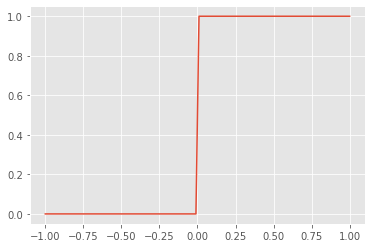

In [72]:
def smoothed_digital(x, K, width=0.001):
    return (np.maximum(x - (K - width), 0) - np.maximum(x - (K + width), 0)) / (
        2 * width
    )


xs = np.linspace(-1, 1, 100)
plt.plot(xs, smoothed_digital(xs, 0))

In [77]:
display(X_df)

,alpha,rho,vol-of-vol,ttm,log-strike,MC_call,MC_digital,MC_call_delta,MC_digital_delta
0,0.296560,-0.722855,2.277405,0.0,0.500000,0.393469,1.0000,1.000000,0.000000
1,0.296560,-0.722855,2.277405,0.0,0.466333,0.372702,1.0000,1.000000,0.000000
2,0.296560,-0.722855,2.277405,0.0,0.432667,0.351223,1.0000,1.000000,0.000000
3,0.296560,-0.722855,2.277405,0.0,0.399000,0.329009,1.0000,1.000000,0.000000
4,0.296560,-0.722855,2.277405,0.0,0.365333,0.306035,1.0000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
96095,0.465708,-0.872419,2.142483,1.0,-0.375333,0.000101,0.0020,0.002892,-0.057636
96096,0.465708,-0.872419,2.142483,1.0,-0.409000,0.000040,0.0006,0.000943,-0.024227
96097,0.465708,-0.872419,2.142483,1.0,-0.442667,0.000019,0.0003,0.000486,-0.007726
96098,0.465708,-0.872419,2.142483,1.0,-0.476333,0.000009,0.0001,0.000170,-0.001598


<AxesSubplot:xlabel='log-strike', ylabel='MC_digital'>

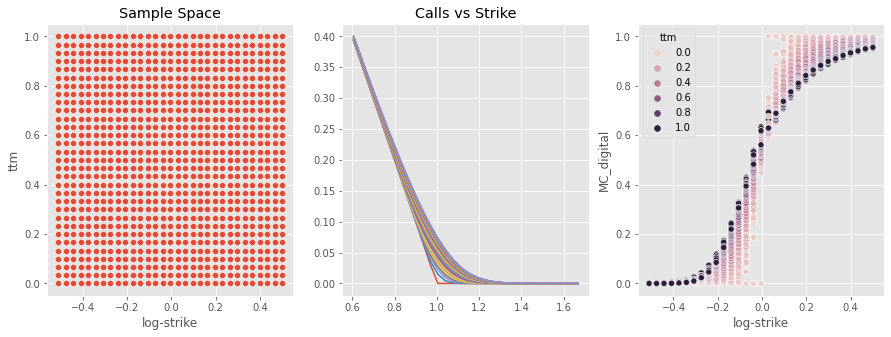

In [78]:
"""
Visualise relationships
"""
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(y=X_df["ttm"], x=X_df["log-strike"], ax=ax[0])
ax[0].set_title("Sample Space")
for i in range(call_surface.shape[0]):
    ax[1].plot(np.exp(k), call_surface[i, :])

# sns.scatterplot(np.exp(-X_df['log-strike']), X_df['call_payoff'], hue = X_df['ttm'], ax = ax[1])
ax[1].set_title("Calls vs Strike")
sns.scatterplot(X_df["log-strike"], X_df["MC_digital"], ax=ax[2], hue=X_df["ttm"])

<AxesSubplot:xlabel='log-strike', ylabel='MC_digital_delta'>

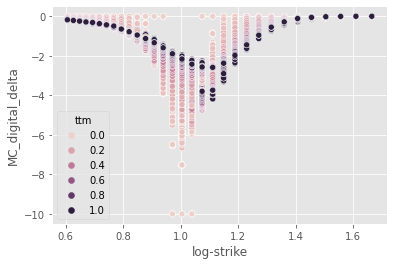

In [79]:
sns.scatterplot(np.exp(-X_df["log-strike"]), X_df["MC_digital_delta"], hue=X_df["ttm"])

<AxesSubplot:xlabel='log-strike', ylabel='MC_call_delta'>

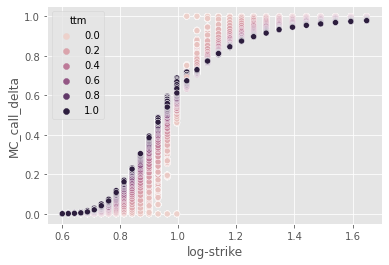

In [84]:
sns.scatterplot(np.exp(X_df["log-strike"]), X_df["MC_call_delta"], hue=X_df["ttm"])